In [1]:
import sys
import logging
import math
import numpy as np
from random import randint
from operator import attrgetter
from skmultiflow.core.utils.utils import *
from skmultiflow.core.base_object import BaseObject
from skmultiflow.classification.base import BaseClassifier
from skmultiflow.classification.trees.hoeffding_tree import *
from skmultiflow.classification.core.driftdetection.adwin import ADWIN

In [2]:
INSTANCE_WEIGHT = np.array([1.0])
FEATURE_MODE_M = ''
FEATURE_MODE_SQRT = 'sqrt'
FEATURE_MODE_SQRT_INV = 'sqrt_inv'
FEATURE_MODE_PERCENTAGE = 'percentage'

In [3]:
class ARFHoeffdingTree(HoeffdingTree):
            
    class RandomLearningNode(HoeffdingTree.ActiveLearningNode):                    
        """Random learning node.
        Parameters
        ----------
        initial_class_observations: dict (class_value, weight) or None
            Initial class observations
        """
        def __init__(self, initial_class_observations, nb_attributes):
            super().__init__(initial_class_observations)
            self.nb_attributes = nb_attributes
            self._is_initialized = False
            self._attribute_observers = []
            self.list_attributes = []         
            
        def learn_from_instance(self, X, y, weight, ht):
            """Update the node with the provided instance.
            Parameters
            ----------
            X: numpy.ndarray of length equal to the number of features.
                Instance attributes for updating the node.
            y: int
                Instance class.
            weight: float
                Instance weight.
            ht: HoeffdingTree
                Hoeffding Tree to update.
            """   
            if not self._is_initialized:
                self._attribute_observers = [None] * len(X)                
                self._is_initialized = True
            if y not in self._observed_class_distribution:
                self._observed_class_distribution[y] = 0.0            
            
            self._observed_class_distribution[y] += weight                            
            if not self.list_attributes:
                self.list_attributes = [None] * self.nb_attributes
                for j in range(self.nb_attributes):    
                    is_unique = False
                    while is_unique == False:
                        self.list_attributes[j] = randint(0, self.nb_attributes - 1)
                        is_unique = True
                        for i in range(j):
                            if self.list_attributes[j] == self.list_attributes[i]:
                                is_unique = False
                                break
            
            for j in range(self.nb_attributes):
                i = self.list_attributes[j]
                obs = self._attribute_observers[i]
                if obs is None:
                    if i in ht.nominal_attributes:
                        obs = NominalAttributeClassObserver()
                    else:
                        obs = GaussianNumericAttributeClassObserver()
                    self._attribute_observers[i] = obs
            obs.observe_attribute_class(X[i], int(y), weight)
            
    class LearningNodeNB(RandomLearningNode):

        def __init__(self, initial_class_observations, nb_attributes):
            super().__init__(initial_class_observations, nb_attributes)            
            
        def get_class_votes(self, X, ht):
            """Get the votes per class for a given instance.
            Parameters
            ----------
            X: numpy.ndarray of length equal to the number of features.
                Instance attributes.
            ht: HoeffdingTree
                Hoeffding Tree.
            Returns
            -------
            dict (class_value, weight)
                Class votes for the given instance.
            """
            if self.get_weight_seen() >= ht.nb_threshold:
                return do_naive_bayes_prediction(X, self._observed_class_distribution, self._attribute_observers)
            else:
                return super().get_class_votes(X, ht)

    class LearningNodeNBAdaptive(LearningNodeNB):
        """Learning node that uses Adaptive Naive Bayes models.
        Parameters
        ----------
        initial_class_observations: dict (class_value, weight) or None
            Initial class observations
        """
        def __init__(self, initial_class_observations, nb_attributes):
            """LearningNodeNBAdaptive class constructor. """
            super().__init__(initial_class_observations, nb_attributes)
            self._mc_correct_weight = 0.0
            self._nb_correct_weight = 0.0

        def learn_from_instance(self, X, y, weight, ht):
            """Update the node with the provided instance.
            Parameters
            ----------
            X: numpy.ndarray of length equal to the number of features.
                Instance attributes for updating the node.
            y: int
                Instance class.
            weight: float
                The instance's weight.
            ht: HoeffdingTree
                The Hoeffding Tree to update.
            """
            if self._observed_class_distribution == {}:
                # All classes equal, default to class 0
                if 0 == y:
                    self._mc_correct_weight += weight
            elif max(self._observed_class_distribution, key=self._observed_class_distribution.get) == y:
                self._mc_correct_weight += weight
            nb_prediction = do_naive_bayes_prediction(X, self._observed_class_distribution, self._attribute_observers)
            if max(nb_prediction, key=nb_prediction.get) == y:
                self._nb_correct_weight += weight
            super().learn_from_instance(X, y, weight, ht)

        def get_class_votes(self, X, ht):
            """Get the votes per class for a given instance.
            Parameters
            ----------
            X: numpy.ndarray of length equal to the number of features.
                Instance attributes.
            ht: HoeffdingTree
                Hoeffding Tree.
            Returns
            -------
            dict (class_value, weight)
                Class votes for the given instance.
            """
            if self._mc_correct_weight > self._nb_correct_weight:
                return self._observed_class_distribution
            return do_naive_bayes_prediction(X, self._observed_class_distribution, self._attribute_observers)
        
    def __init__(self, max_byte_size = 33554432, memory_estimate_period = 1000000, grace_period = 200,
                     split_criterion = 'info_gain', split_confidence = 0.0000001, tie_threshold = 0.05, 
                     binary_split = False, stop_mem_management = False, remove_poor_atts = False, no_preprune = False, 
                     leaf_prediction = 'mc', nb_threshold = 0, nominal_attributes = None, nb_attributes = 2):                
        """ADFHoeffdingTree class constructor."""
        super().__init__(max_byte_size, memory_estimate_period, grace_period, split_criterion, split_confidence,
                        tie_threshold, binary_split, stop_mem_management, remove_poor_atts, no_preprune,
                        leaf_prediction, nb_threshold, nominal_attributes)
        self.nb_attributes = nb_attributes
        self.remove_poor_attributes_option = None        

    def _new_learning_node(self, initial_class_observations = None):   
        """Create a new learning node. The type of learning node depends on the tree configuration."""
        if initial_class_observations is None:
            initial_class_observations = {}        
        if self._leaf_prediction == MAJORITY_CLASS:
            return self.RandomLearningNode(initial_class_observations, self.nb_attributes)            
        elif self._leaf_prediction == NAIVE_BAYES:
            return self.LearningNodeNB(initial_class_observations, self.nb_attributes)            
        else: #NAIVE_BAYES_ADAPTIVE
            return self.LearningNodeNBAdaptative(initial_class_observations, self.nb_attributes)
        
    def is_randomizable():  
        return True

In [4]:
class AdaptiveRandomForest(BaseClassifier):
    
    def __init__(self, nb_ensemble = 10, feature_mode = 'sqrt', nb_attributes = 2, 
                 disable_background_learner = False, disable_drift_detection = False, 
                 disable_weighted_vote = False, w = 6, drift_detection_method = ADWIN, 
                 warning_detection_method = ADWIN):
        
        """AdaptiveRandomForest class constructor."""
        super().__init__()          
        self.nb_ensemble = nb_ensemble        
        self.feature_mode = feature_mode
        self.total_attributes = nb_attributes
        self.disable_background_learner = disable_background_learner   
        self.disable_drift_detection = disable_drift_detection        
        self.disable_weighted_vote = disable_weighted_vote
        self.w = w
        self.drift_detection_method = drift_detection_method
        self.warning_detection_method = warning_detection_method
        self.X_seen = 0   
        self._train_weight_seen_by_model = 0.0
        self.nb_attributes = None
        self.ensemble = None              

    def fit(self, X, y, classes = None, weight = None):
        raise NotImplementedError
    
    def partial_fit(self, X, y, classes = None, weight = None):
        if y is not None:
            if weight is None:
                weight = INSTANCE_WEIGHT
            row_cnt, _ = get_dimensions(X)
            wrow_cnt, _ = get_dimensions(weight)
            if row_cnt != wrow_cnt:
                weight = [weight[0]] * row_cnt
            for i in range(row_cnt):
                if weight[i] != 0.0:
                    self._train_weight_seen_by_model += weight[i]
                    self._partial_fit(X[i], y[i], weight[i])
        
    def _partial_fit(self, X, y, weight):
        self.X_seen += 1
        
        if not self.ensemble:
            self.init_ensemble(X)
                      
        for i in range(self.nb_ensemble):
            vote = self.ensemble[i].get_votes_for_instance(X)
            k = np.random.poisson(self.w)
            if k > 0:
                self.ensemble[i].partial_fit(np.asarray([X]), np.asarray([y]), np.asarray([k]), self.X_seen)            
    
    def predict(self, X):
        """Predicts the label of the X instance(s)
        Parameters
        ----------
        X: numpy.ndarray of shape (n_samples, n_features)
            Samples for which we want to predict the labels.
        Returns
        -------
        list
            Predicted labels for all instances in X.
        """
        r, _ = get_dimensions(X)
        predictions = []
        for i in range(r):
            votes = self.get_votes_for_instance(X[i])
            if votes == {}:
                # Tree is empty, all classes equal, default to zero
                predictions.append(0)
            else:

                predict = []
                
                for vote in votes:                                        
                    predict.append(max(vote, key = vote.get))
                
                (values, counts) = np.unique(predict, return_counts=True)
                ind = np.argmax(counts)
                
                predictions.append(values[ind])
                
        return predictions

    def predict_proba(self, X):
        raise NotImplementedError
        
    def reset(self):        
        """Reset attributes."""
        self.ensemble = None
        self.nb_attributes = 0
        self.X_seen = 0
        self._train_weight_seen_by_model = 0.0
        
    def score(self, X, y):
        raise NotImplementedError
        
    def get_info(self):
        raise NotImplementedError
        
    def get_votes_for_instance(self, X):
        test = X.copy()
        if not self.ensemble:
            self.init_ensemble(test)
        combined_vote = []
           
        for i in range(self.nb_ensemble):
            vote = self.ensemble[i].get_votes_for_instance(test)
            if sum(vote) > 0:
                combined_vote.append(vote)
        
        return combined_vote
        
    def init_ensemble(self, X):
        self.ensemble = [None] * self.nb_ensemble
        
        self.nb_attributes = self.total_attributes
        
        """The m (total number of attributes) depends on:"""
        _, n = get_dimensions(X)
        
        if self.feature_mode == FEATURE_MODE_SQRT:
            self.nb_attributes = int(round(math.sqrt(n)) + 1)            
        elif self.feature_mode == FEATURE_MODE_SQRT_INV:
            self.nb_attributes = n - int(round(math.sqrt(n) + 1))
        elif self.feature_mode == FEATURE_MODE_PERCENTAGE:            
            percent = (100 + self.nb_attributes) / 100.0 if self.nb_attributes < 0 else self.nb_attributes / 100.0
            self.nb_attributes = int(round(n * percent))
            
        """Notice that if the selected feature_mode was FEATURE_MODE_M then nothing is performed, 
        still it is necessary to check (and adjusted) for when a negative value was used. 
        """
        
        """m is negative, use size(features) + -m"""
        if self.nb_attributes < 0:
            self.nb_attributes += n
        """Other sanity checks to avoid runtime errors."""
        """m <= 0 (m can be negative if nb_attributes was negative and abs(m) > n), then use m = 1"""
        if self.nb_attributes <= 0:
            self.nb_attributes = 1
        """m > n, then it should use n"""
        if self.nb_attributes > n:
            self.nb_attributes = n
                               
        for i in range(self.nb_ensemble):            
            self.ensemble[i] = self.ARFBaseLearner(i, ARFHoeffdingTree(nb_attributes = self.nb_attributes), 
                                              self.X_seen, 
                                              not self.disable_background_learner, 
                                              not self.disable_drift_detection,
                                              self.drift_detection_method,
                                              self.warning_detection_method,
                                              False)            
                    
    def is_randomizable():  
        return True                
            
    class ARFBaseLearner(BaseObject):

        def __init__(self, index_original, classifier, X_seen, use_background_learner, use_drift_detector, 
                     drift_detection_method, warning_detection_method, is_background_learner):            
            self.index_original = index_original
            self.classifier = classifier 
            self.created_on = X_seen
            self.use_background_learner = use_background_learner
            self.use_drift_detector = use_drift_detector
            self.is_background_learner = is_background_learner
            self.drift_detection_method = warning_detection_method
            self.warning_detection_method = warning_detection_method
                                   
            self.last_drift_on = 0
            self.last_warning_on = 0
            self.nb_drifts_detected = 0
            self.nb_warnings_detected = 0            

            self.drift_detection = None
            self.warning_detection = None
            self.background_learner = None

            if use_background_learner:
                self.warning_detection = warning_detection_method()
            
            if use_drift_detector:
                self.drift_detection = drift_detection_method()
            
        def reset(self, X_seen):
            if self.use_background_learner and self.background_learner:
                self.classifier = self.background_learner.classifier 
                self.warning_detection = self.background_learner.warning_detection
                self.drift_detection = self.background_learner.drift_detection
                self.created_on = self.background_learner.created_on                
                self.background_learner = None
            else:
                self.classifier.reset()
                self.created_on = X_seen
                self.drift_detection = self.drift_detection_method()            

        def partial_fit(self, X, y, weight, X_seen):
            X_weighted = X.copy()
            self.classifier.partial_fit(X_weighted, y, weight)
            
            if self.background_learner:
                self.background_learner.classifier.partial_fit(X, y, INSTANCE_WEIGHT)

            if self.use_drift_detector and not self.is_background_learner:
                correctly_classifies = self.classifier.predict(X) == y
                # Check for warning only if use_background_learner is active
                if self.use_background_learner:
                    self.warning_detection.add_element(int(not correctly_classifies))
                    # Check if there was a change
                    if self.warning_detection.detected_change():
                        self.last_warning_on = X_seen
                        self.nb_warnings_detected += 1
                        # Create a new background tree classifier
                        background_learner = self.classifier.copy()
                        background_learner.reset() 
                        # Create a new background learner object
                        self.background_learner = ARFBaseLearner(index_original, background_learner, 
                                                                 X_seen, self.use_background_learner, 
                                                                 self.use_drift_detector, self.drift_detection_method, 
                                                                 self.warning_detection_method, True)
                        """Update the warning detection object for the current object 
                        (this effectively resets changes made to the object while it was still a bkg learner). 
                        """
                        self.warning_detection = self.drift_detection_method()

            # Update the drift detection
            self.drift_detection.add_element(int(not correctly_classifies))

            # Check if there was a change
            if self.drift_detection.detected_change():
                self.last_drift_on = X_seen
                self.nb_drifts_detected += 1
                self.reset(X_seen)

        def get_votes_for_instance(self, X):
            return self.classifier.get_votes_for_instance(X)
        
        def get_class_type(self):
            raise NotImplementedError
        
        def get_info(self):
            raise NotImplementedError

# Tests for ADFHoeffdingtree.

## For the following part we test the ADFHoeffdingtree algorithm according to several parameters:
    -If the stream is created with a csv file or with the waveformgenerator()
    
    -We test for 3 datasets: covtype, movingSquares and sea_stream.
    
        -covtype: The forest covertype data set represents forest cover type for 30 x30 meter cells obtained from the US Forest Service Region 2 Resource InformationSystem (RIS) data. Each class corresponds to a diﬀerent cover type. This dataset contains 581,012 instances, 54 attributes (10 numeric and 44 binary) and 7imbalanced class labels. 
       
       -movingsquares:
        
       -sea_stream: The SEA generator produces data streams with three continuousattributes (f1, f2, f3). The range of values that each attribute can assume is be-tween 0 and 10. Only the ﬁrst two attributes (f1, f2) are relevant, i.e., f3doesnot inﬂuence the class value determination. New instances are obtained throughrandomly setting a point in a two dimensional space, such that these dimensionscorresponds to f1and f2. This two dimensional space is split into four blocks,each of which corresponds to one of four diﬀerent functions. In each block a pointbelongs to class 1 if f1+f2≤θand to class 0 otherwise. The threshold θusedto split instances between class 0 and 1 assumes values 8 (block 1), 9 (block 2), 7(block 3) and 9.5 (block 4). It is possible to add noise to class values, being thedefault value 10%, and to balance the number of instances of each class. SEAgsimulates 3 gradual drifts, while SEAasimulates 3 abrupt drifts 

Adaptive random forests for evolving data stream classification (PDF Download Available). Available from: https://www.researchgate.net/publication/317579226_Adaptive_random_forests_for_evolving_data_stream_classification [accessed Feb 11 2018].
       
    -We use 2 evaluators: Prequential and Holdout. Hold-out is more accurate, but needs data for testing.
    
        -Prequential:The error of a model is computed from the sequence of examples. 
        For each example in the stream, the actual model makes a prediction, and then uses it to update the model.
        
        -Holdout:Apply the current decision model to the test set,at regular time intervals 
        The loss estimated in the hold out is an unbiased estimator
        
    -Finally we compare the model with a naive bayes model, BernoulliNB, with the accuracy and the Kappa statistic.
        
        -Accuracy:
        
        -Kappa statistic: k=1 the classifier is always correct. 
                          k=0 the predictions coincide with the correct ones as often as those of the chance classifier
        
        
ADFHoeffdingtree with wave form generator stream

root - INFO - Holdout Evaluation
root - INFO - Generating 3 targets.
root - INFO - Pretraining on 100 samples.
skmultiflow.classification.trees.hoeffding_tree - INFO - No Nominal attributes have been defined, will consider all attributes as numerical
skmultiflow.classification.trees.hoeffding_tree - INFO - No Nominal attributes have been defined, will consider all attributes as numerical
skmultiflow.classification.trees.hoeffding_tree - INFO - No Nominal attributes have been defined, will consider all attributes as numerical
skmultiflow.classification.trees.hoeffding_tree - INFO - No Nominal attributes have been defined, will consider all attributes as numerical
skmultiflow.classification.trees.hoeffding_tree - INFO - No Nominal attributes have been defined, will consider all attributes as numerical
skmultiflow.classification.trees.hoeffding_tree - INFO - No Nominal attributes have been defined, will consider all attributes as numerical
skmultiflow.classification.trees.hoeffding_tree -

ZeroDivisionError: division by zero

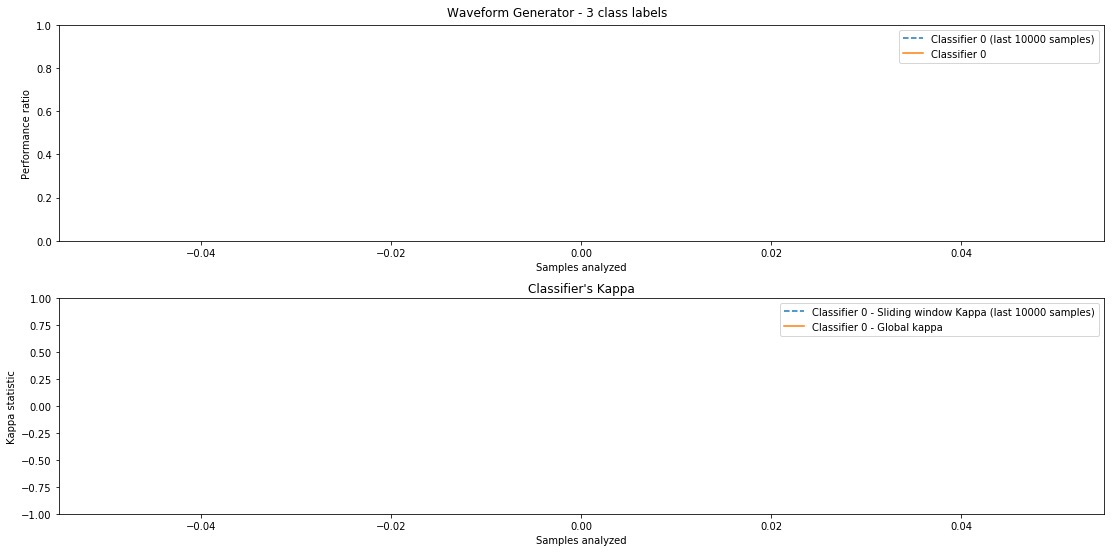

In [9]:
from skmultiflow.data.generators.waveform_generator import WaveformGenerator
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.evaluation.evaluate_holdout import EvaluateHoldout

# 1. Create a stream
stream = WaveformGenerator()
stream.prepare_for_use()

# 2. Instantiate the classifier
adf = AdaptiveRandomForest()

# 3. Setup the evaluator
eval = EvaluateHoldout(show_plot=True, pretrain_size=100, max_instances=10000)

# 4. Run evaluation
eval.eval(stream=stream, classifier=adf)

1. Error estimation: Hold-out or Prequential
2. Evaluation performance measures: Accuracy or κ-statistic 


Eval Holdout with datasets.csv for ARF 


In [ ]:
from skmultiflow.options.file_option import FileOption
from skmultiflow.data.file_stream import FileStream
from skmultiflow.classification.trees.hoeffding_tree import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.evaluation.evaluate_holdout import EvaluateHoldout


# 1. Create a stream
options = FileOption(option_value="../datasets/covtype.csv", file_extension="CSV")
#options = FileOption(option_value="../datasets/movingSquares.csv", file_extension="CSV")
#options = FileOption(option_value="../datasets/sea_stream.csv", file_extension="CSV")

stream = FileStream(options)

stream.prepare_for_use()

# 2. Instantiate the classifier
adf = AdaptiveRandomForest()

# 3. Setup the evaluator
eval = EvaluateHoldout(pretrain_size=200, max_instances=10000, batch_size=1, max_time=1000, output_file='resultsHoldout.csv', task_type='classification', show_plot=False, plot_options=['kappa', 'performance'], test_size=5000, dynamic_test_set=True)

# 4. Run evaluation
eval.eval(stream=stream, classifier=adf)

compare ARF AND NAIVE BAYES classifiers with holdout

In [ ]:
# The second example will demonstrate how to compare two classifiers with
# the EvaluateHoldout
from skmultiflow.evaluation.evaluate_holdout import EvaluateHoldout

from sklearn.naive_bayes import BernoulliNB

options = FileOption(option_value="../datasets/covtype.csv", file_extension="CSV")
#options = FileOption(option_value="../datasets/movingSquares.csv", file_extension="CSV")
#options = FileOption(option_value="../datasets/sea_stream.csv", file_extension="CSV")
stream = FileStream(options)

stream.prepare_for_use()

clf_one = BernoulliNB()
clf_two = AdaptiveRandomForest()
classifier = [clf_one, clf_two]

eval = EvaluateHoldout(pretrain_size=200, test_size=5000, dynamic_test_set=True, max_instances=100000, batch_size=1,  max_time=1000, output_file='comparison_Bernoulli_ADFH_Holdout.csv', task_type='classification', show_plot=False, plot_options=['kappa', 'performance'])
eval.eval(stream=stream, classifier=classifier)

In [ ]:
# Verification of the same result for ADFHoeffdingTree
from skmultiflow.core.pipeline import Pipeline
from skmultiflow.data.file_stream import FileStream
from skmultiflow.options.file_option import FileOption
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.classification.trees.hoeffding_tree import HoeffdingTree


# Setup the File Stream
opt = FileOption("FILE", "OPT_NAME", "../datasets/covtype.csv", "CSV", False)
#opt = FileOption("FILE", "OPT_NAME", "../datasets/movingSquares.csv", "CSV", False)
#opt = FileOption("FILE", "OPT_NAME", "../datasets/sea_stream.csv", "CSV", False)
stream = FileStream(opt, -1, 1)
stream.prepare_for_use()

# Setup the classifiers
clf_one = HoeffdingTree()
clf_two = AdaptiveRandomForest()

# Setup the pipeline for clf_one
pipe = Pipeline([('Classifier', clf_one)])

# Create the list to hold both classifiers
classifier = [pipe, clf_two]

# Setup the evaluator
eval = EvaluateHoldout(pretrain_size=200, max_instances=100000, batch_size=1, max_time=1000, output_file='comparison_Hoeffding_ADFH_Preq.csv', task_type='classification', plot_options=['kappa', 'kappa_t', 'performance'])

# Evaluate
eval.eval(stream=stream, classifier=classifier)